In [6]:
from lines_model import load_model
import torch
from tqdm import tqdm
import pickle
from lines_dataset import LineSegmentDataset, DataLoader
import glob
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

device_name = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)

In [34]:
# Load the model
save_path = "./checkpoints/Lines_combined.pt"
model = load_model(target_device=device_name, path_to_checkpoint=save_path)

Successfully Loaded Saved Model


/media/github/school/master1/artifical-intelligence/computer-vision-2/projective-geometry/line_segment/lines_model.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mode

In [81]:
def calculate_scores(images, labels):
    images = images.to(device)
    labels = labels.to(device)

    # Calculate the scores using the model
    model.eval()
    with torch.no_grad():
        outputs = model(images)

    # Calculate the accuracy
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == labels).sum().item() / len(labels)

    # scores is a tensor of shape (batch_size, num_classes), so [Nx2] 2 for real and fake
    # Calcuate the mean and std of the scores
    scores = outputs.cpu().numpy()
    mean_scores = scores.mean(axis=0)
    std_scores = scores.std(axis=0)

    # Return the accuracy, mean scores, and std scores
    return {
        "accuracy": accuracy,
        "Real Score": mean_scores[0],
        "Generated Score": mean_scores[1],
        "real_score_std": std_scores[0],
        "generated_score_std": std_scores[1]
    }


In [82]:
videos = [
     "castle",
     "castle_gen",
     "garden",
     "garden_gen",
     "mountain",
     "mountain_gen",
     "river",
     "river_gen",
     "pathway",
     "pathway_gen"
]

performance = {}
"""Contains the performance of the model on each video."""

for video in videos:
    # if directory does not exist, continue
    if not os.path.exists(f"assets/videos/{video}.mp4_frames"):
        print(f"Directory {video} does not exist, skipping...")
        continue

    if not os.path.exists(f"./lines/{video}_lines.pkl"):
        print(f"Lines file {video} does not exist, skipping...")
        continue

    class_to_idx = {f'{video}.mp4_frames': not "_gen" in video}

    # Get all files in the {video} directory
    image_paths = sorted(glob.glob(f"assets/videos/{video}.mp4_frames/*"))
    image_path_to_lines = pickle.load(open(f"./lines/{video}_lines.pkl", "rb"))

    dataset = LineSegmentDataset(image_paths, image_path_to_lines, class_to_idx)
    dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

    for images, labels in tqdm(dataloader, desc="testing"):
        performance[video] = calculate_scores(images, labels)

testing: 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]


Lines file mountain does not exist, skipping...


testing: 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]


Directory river does not exist, skipping...
Directory river_gen does not exist, skipping...


testing: 100%|██████████| 1/1 [00:00<00:00,  7.07it/s]


/tmp/ipykernel_805350/1732085880.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')


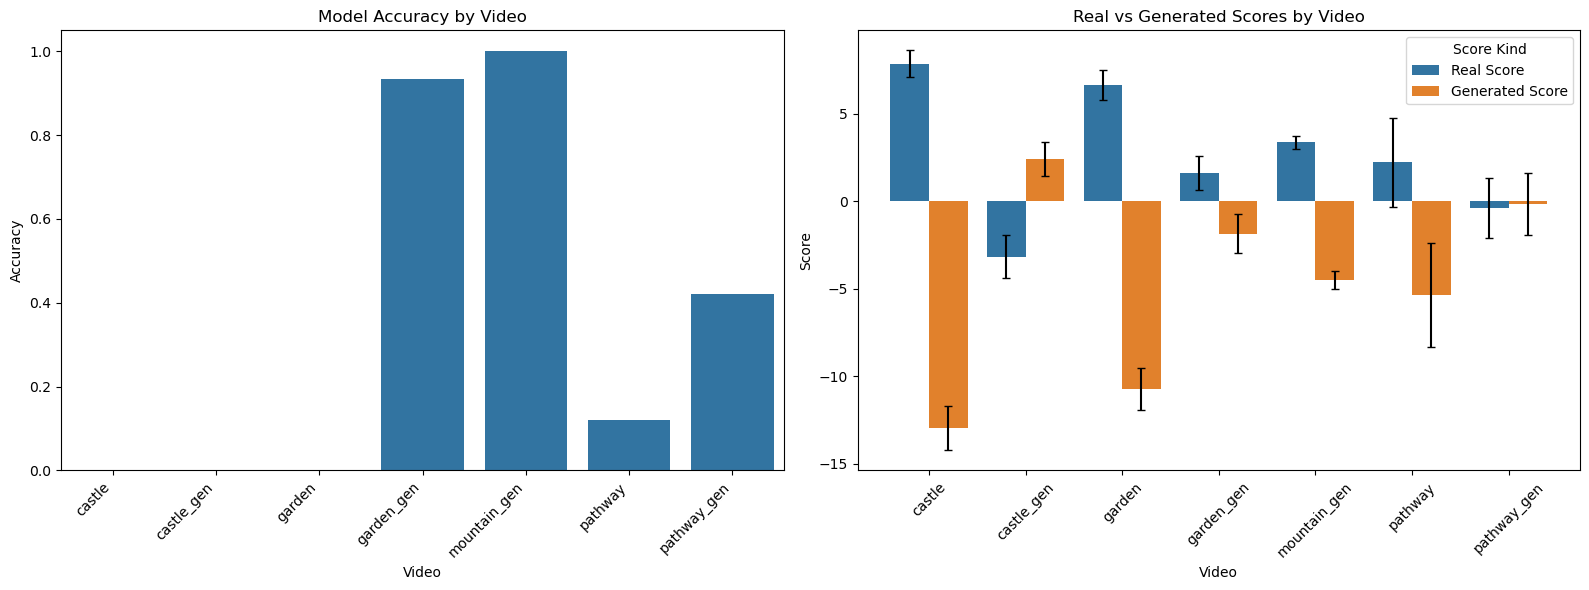

In [84]:
df = pd.DataFrame.from_dict(performance, orient='index').reset_index()
df.rename(columns={'index': 'video'}, inplace=True)

# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot accuracy
sns.barplot(x='video', y='accuracy', data=df, ax=ax1)
ax1.set_title('Model Accuracy by Video')
ax1.set_xlabel('Video')
ax1.set_ylabel('Accuracy')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
# Plot scores comparison
df_scores = df[['video', 'Real Score', 'Generated Score', 'real_score_std', 'generated_score_std']].melt(
    id_vars=['video'],
    value_vars=['Real Score', 'Generated Score'],
    var_name='Score Kind',
    value_name='score'
)

# Add std values for error bars
df_scores['score_std'] = df_scores.apply(
    lambda row: df.loc[df['video'] == row['video'],
        'real_score_std' if row['Score Kind'] == 'Real Score' else 'generated_score_std'
    ].values[0], axis=1
)

# Plot with error bars
sns.barplot(
    x='video',
    y='score',
    hue='Score Kind',
    data=df_scores,
    ax=ax2,
    capsize=0.1,
    err_kws={'color': 'black', 'linewidth': 1},
)
# Add error bars manually since some seaborn versions handle it differently
for i, bar in enumerate(ax2.patches):
    # Skip the bar if its data is not valid (e.g., if it is a zero-width bar)
    if bar.get_width() == 0:
        continue
    # Get the index in the df_scores dataframe
    idx = i % len(df_scores)
    # Get the standard deviation for this bar
    err = df_scores.iloc[idx]['score_std']
    # Plot the error bar
    ax2.errorbar(bar.get_x() + bar.get_width()/2,
                bar.get_height(),
                yerr=err,
                fmt='none',
                color='black',
                capsize=3)

ax2.set_title('Real vs Generated Scores by Video')
ax2.set_xlabel('Video')
ax2.set_ylabel('Score')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()